# Analysis of the Cognitive Control Design Space with MOFA+

This notebook trains and analyzes a Multi-Omics Factor Analysis (MOFA+) model on the cognitive control literature dataset. The goal is to extend the initial PCA by using a more flexible, probabilistic framework capable of handling heterogeneous data types and inferring robust latent factors.

The workflow is as follows:
1.  **Load and Preprocess Data**: Use the `mofa_utils.py` script to transform the wide-format CSV into the long format required by `mofapy2`.
2.  **Train the MOFA+ Model**: Configure and run the `mofapy2` training pipeline. This step is computationally intensive and the model will be saved to disk to avoid re-running.
3.  **Analyze the Trained Model**: Use the `mofax` library to load the saved model and analyze its components:
    *   **Variance Explained**: Determine the importance of each factor.
    *   **Latent Space Visualization**: Plot the factors to visualize the structure of the experimental space, analogous to a PCA plot.
    *   **Factor Interpretation**: Examine the feature weights to understand the conceptual meaning of each latent factor.
4.  **Advanced Analysis**: Discuss the path towards advanced analyses like interpolation, highlighting the differences from the PCA workflow.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plot
import pickle
from IPython.display import display
from pathlib import Path
import pickle
import analysis_utils as au
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# MOFA+ libraries
from mofapy2.run.entry_point import entry_point
import mofax as mfx

# Setup plotting style and display options
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
print("Libraries loaded successfully.")
ard_factors = True
print(f"Configuring model to use ard_factors={ard_factors}.")
# Define the model folder and file path
model_folder_path = Path("mofa_models")

Libraries loaded successfully.
Configuring model to use ard_factors=True.


In [3]:
# Load the raw dataset
try:
    df_raw = pd.read_csv('./data/super_experiment_design_space.csv', keep_default_na=False)
    df_raw = pd.DataFrame(df_raw).replace('N/A', np.nan)
    print(f"Successfully loaded raw dataset. Shape: {df_raw.shape}")
except FileNotFoundError:
    print("Error: './data/super_experiment_design_space.csv' not found.")
# Preprocess the data into the long format required by mofapy2
df_long, preprocessor, likelihoods = au.preprocess_for_mofa(df_raw)
print("\nPreprocessing for MOFA+ complete.")
# Create the folder if it doesn't exist
os.makedirs(model_folder_path, exist_ok=True)
preprocessor_path = model_folder_path / "preprocessor.pkl"

# store the preprocessor on disk in case we want to invert points and we need to go back to the original space
pickle.dump(preprocessor, open(preprocessor_path, 'wb'))

print("\nSample of the long-format data:")
display(df_long.head(20))
print("Data for Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCSI Pure Trials:")
display(df_long[df_long['sample']=='Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCSI Pure Trials'])

Successfully loaded raw dataset. Shape: (349, 24)

Preprocessing for MOFA+ complete.

Sample of the long-format data:


,sample,feature,value,view,group
0,Telford 1931 Auditory RT (500ms SOA),num__Task 2 Response Probability,2.194691,Structure,all_studies
1,Telford 1931 Auditory RT (1000ms SOA),num__Task 2 Response Probability,2.194691,Structure,all_studies
2,Telford 1931 Auditory RT (2000ms SOA),num__Task 2 Response Probability,2.194691,Structure,all_studies
3,Telford 1931 Auditory RT (4000ms SOA),num__Task 2 Response Probability,2.194691,Structure,all_studies
4,Telford 1931 Line Length (1000ms SOA),num__Task 2 Response Probability,2.194691,Structure,all_studies
5,Telford 1931 Line Length (2000ms SOA),num__Task 2 Response Probability,2.194691,Structure,all_studies
6,Telford 1931 Line Length (4000ms SOA),num__Task 2 Response Probability,2.194691,Structure,all_studies
7,Telford 1931 Line Length (8000ms SOA),num__Task 2 Response Probability,2.194691,Structure,all_studies
8,"Telford 1931 Number Assoc. (Adults, 1000ms SOA)",num__Task 2 Response Probability,2.194691,Structure,all_studies
9,"Telford 1931 Number Assoc. (Adults, 2000ms SOA)",num__Task 2 Response Probability,2.194691,Structure,all_studies


Data for Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCSI Pure Trials:


,sample,feature,value,view,group
130,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__Task 2 Response Probability,-0.455645,Structure,all_studies
479,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__Inter-task SOA,-0.123807,Temporal,all_studies
828,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__Distractor SOA,-0.168938,Temporal,all_studies
1177,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__Task 1 CSI,-0.102364,Temporal,all_studies
1526,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__Task 2 CSI,-0.276928,Temporal,all_studies
1875,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__RSI,0.188002,Temporal,all_studies
2224,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__Switch Rate,-0.818911,Context,all_studies
2573,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__Task 1 Difficulty,1.110921,Task_Properties,all_studies
2922,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,num__Task 2 Difficulty,0.000000,Task_Properties,all_studies
3271,Rubin & Meiran (2005) Exp 1 Uni NoFilt ShortCS...,cat__Inter_task_SOA_is_NA_1,1.000000,Structure,all_studies


In [4]:
# --- Configuration ---
def train_model(ard_factors=False):
    MODEL_OUTFILE = f"mofa_models/cognitive_control_conditions_ard_factors_{ard_factors}_model.hdf5"
    N_FACTORS = 15 # The initial number of factors to learn
    
    # To save time, we check if the model has already been trained.
    if not os.path.exists(MODEL_OUTFILE):
        print("Model file not found. Training a new MOFA+ model...")
        
        # 1. Initialize the entry point
        ent = entry_point()
    
        # 2. Set the data from the preprocessed long DataFrame
        # The likelihoods correspond to the views in alphabetical order
        ent.set_data_df(df_long, likelihoods=likelihoods)
    
        # 3. Set model options
        # - factors: Initial number of latent dimensions to learn.
        # - spikeslab_weights: Enforces sparsity, pushing non-informative weights to zero. Crucial for interpretability.
        ent.set_model_options(
            factors=N_FACTORS,
            spikeslab_weights=True, 
            ard_weights=True,
            ard_factors=ard_factors
        )
    
        # 4. Set training options
        # - iter: Maximum number of iterations.
        # - convergence_mode: 'fast' is good for exploration.
        # - dropR2: Automatically drops factors explaining less than this variance threshold during training.
        # - seed: For reproducibility.
        ent.set_train_options(
            iter=1000,
            convergence_mode="fast",
            dropR2=0.001, 
            seed=2024
        )
        
        # 5. Build, run, and save the model
        print("Building model...")
        ent.build()
        
        print("\nRunning model training (this may take several minutes)...")
        ent.run()
        
        print(f"\nSaving trained model to {MODEL_OUTFILE}...")
        # Ensure the directory exists
        os.makedirs(os.path.dirname(MODEL_OUTFILE), exist_ok=True)
        ent.save(MODEL_OUTFILE)
        
        print("Model training complete.")
    else:
        print(f"Found existing model file at {MODEL_OUTFILE}. Skipping training.")

In [5]:
train_model(ard_factors)

Model file not found. Training a new MOFA+ model...

        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        


Loaded group='all_studies' view='Conflict' with N=349 samples and D=8 features...
Loaded group='all_studies' view='Context' with N=349 samples and D=6 features...
Loaded group='all_studies' view='Rules' with N=349 samples and D=10 features...
Loaded group='all_studies' view='Structure' with N=349 samples and D=9 features...
L

In [6]:
MODEL_OUTFILE = f"mofa_models/cognitive_control_conditions_ard_factors_{ard_factors}_model.hdf5"
# Load the trained model using the mofax library for analysis
try:
    model = mfx.mofa_model(MODEL_OUTFILE)
    print("Trained MOFA+ model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    model = None

if model:
    # Inspect the basic properties of the model
    print(f"\nNumber of experiments (samples): {model.shape[0]}")
    print(f"Number of parameters (features): {model.shape[1]}")
    print(f"Number of factors inferred: {model.nfactors}")
    print(f"Data views: {model.views}")
    print(f"Sample groups: {model.groups}")

Trained MOFA+ model loaded successfully.

Number of experiments (samples): 349
Number of parameters (features): 40
Number of factors inferred: 3
Data views: [np.str_('Conflict'), np.str_('Context'), np.str_('Rules'), np.str_('Structure'), np.str_('Task_Properties'), np.str_('Temporal')]
Sample groups: [np.str_('all_studies')]


The R² value for each factor shows how much of the variance in the experimental parameters it explains. This is the primary way to assess a factor's importance. We can break this down by *view* (parameter type) or *group* (paradigm class).

--- Variance Explained (R²) per Factor and View ---


,Factor,View,Group,R2
0,Factor1,Conflict,all_studies,4.639099
1,Factor1,Context,all_studies,53.516217
2,Factor1,Rules,all_studies,19.103661
3,Factor1,Structure,all_studies,19.701928
4,Factor1,Task_Properties,all_studies,6.070087


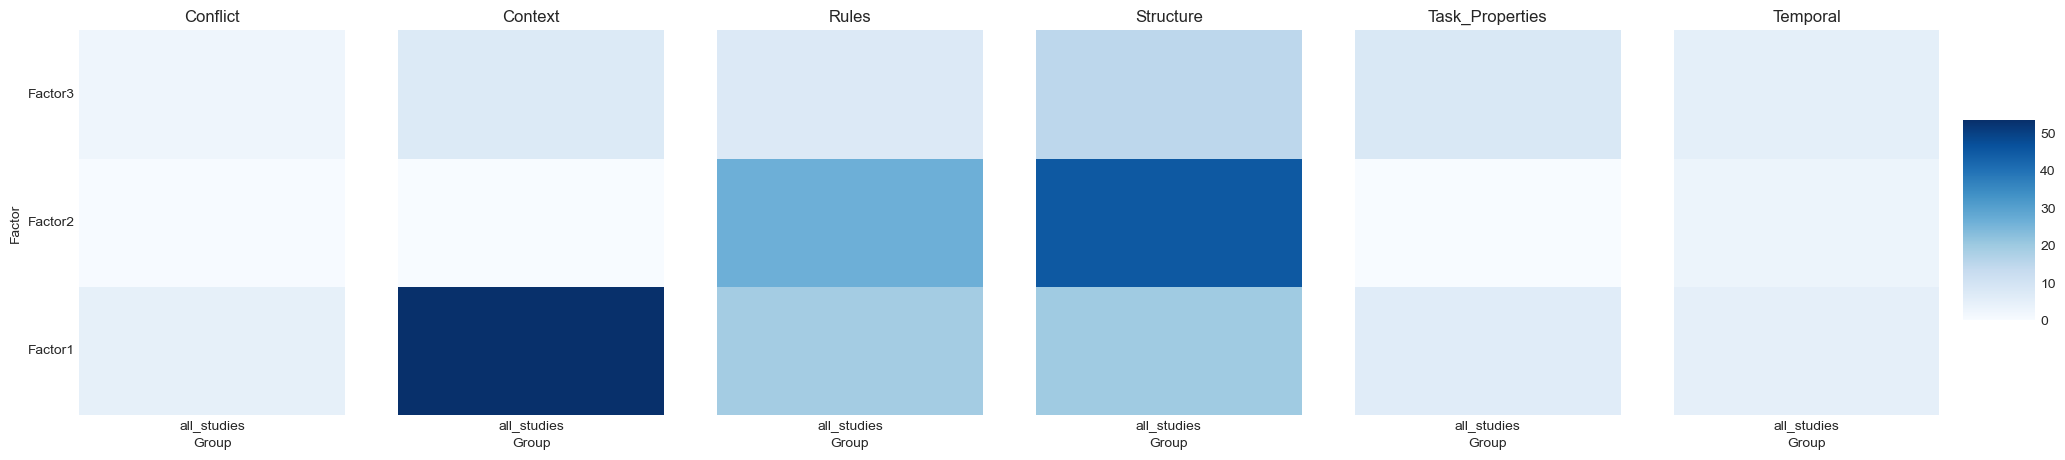

In [7]:
if model:
    # Get the R² values as a DataFrame
    r2_df = model.get_variance_explained()
    print("--- Variance Explained (R²) per Factor and View ---")
    display(r2_df.head())
    
    # Create a heatmap of the R² values
    # This shows which factors are most important for which paradigm classes.
    #fig, ax = plt.subplots(figsize=(8, 6))
    fig = mfx.plot_r2(model, x='Group', y='Factor')
    fig.savefig("r2_mofa.png", bbox_inches='tight')
    fig

To understand what a factor *means*, we must examine its weights. Features (experimental parameters) with high positive or negative weights are the ones that define that factor.

--- Generating custom plot for Factor 1 ---


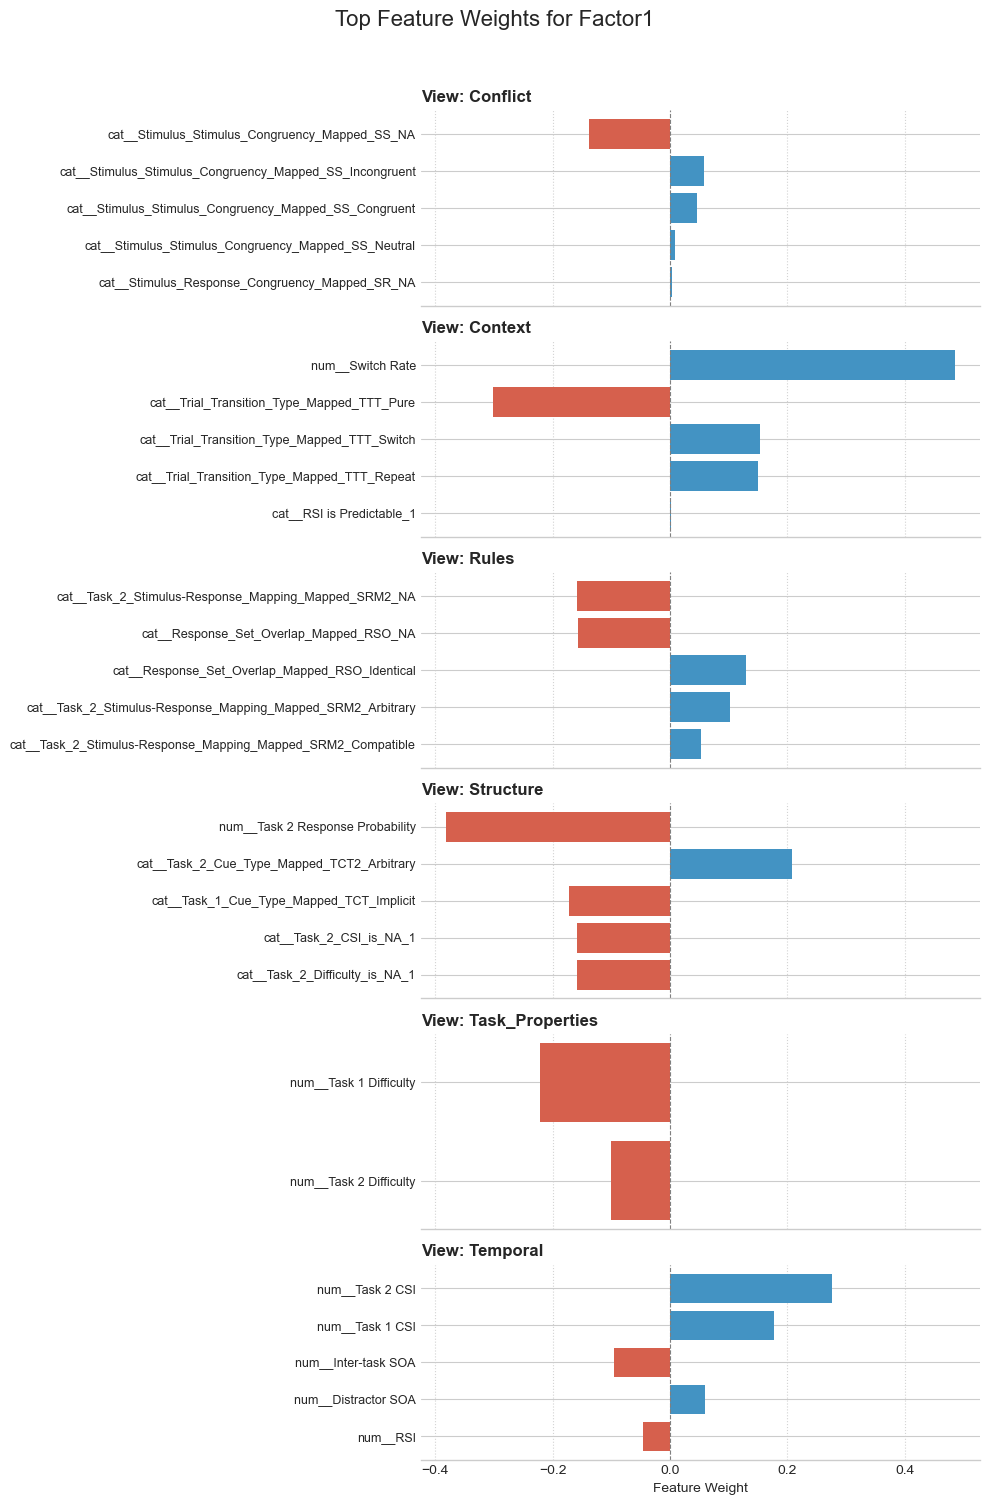

--- Generating custom plot for Factor 2 ---


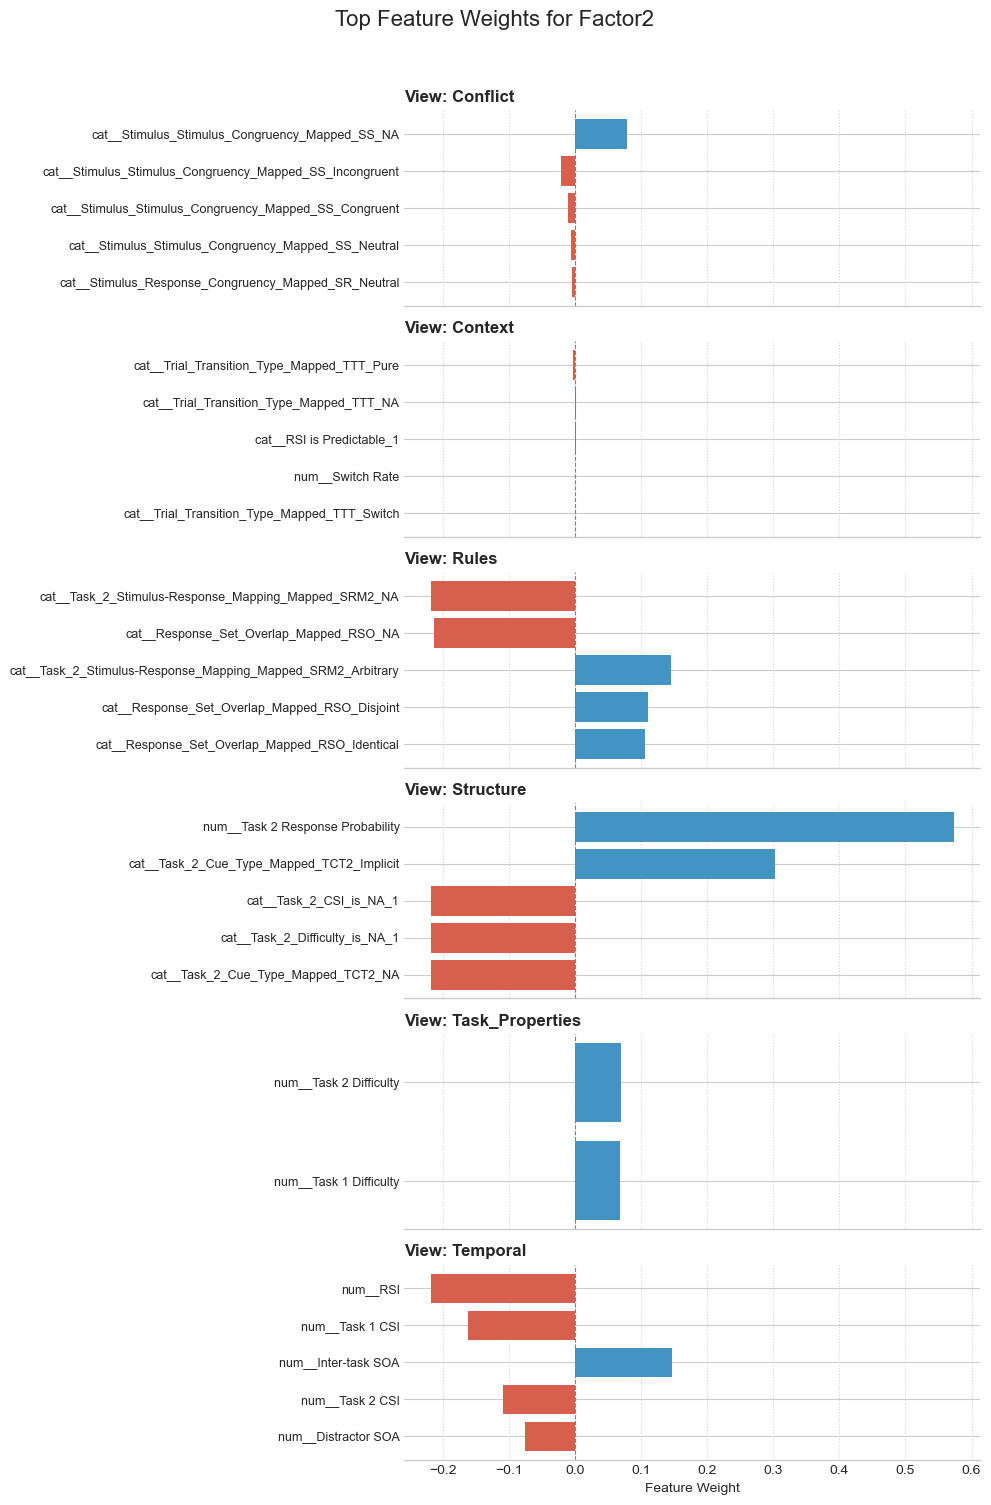

In [8]:
# --- How to use the new function ---
if model:
    print("--- Generating custom plot for Factor 1 ---")
    fig1 = plot.plot_factor_weights_by_view(model, "Factor1", n_features_per_view=5)
    plt.savefig("factor_1_weights_custom.png")
    plt.show()

    print("--- Generating custom plot for Factor 2 ---")
    fig2 = plot.plot_factor_weights_by_view(model, "Factor2", n_features_per_view=5)
    plt.savefig("factor_2_weights_custom.png")
    plt.show()


      
The plot below is the direct analog of the PCA scatter plot. Each point is an experimental condition, plotted in the space defined by the latent factors. We color by the paradigm class (group) assigned during preprocessing to see if the factors successfully separate these classes.

    

In [9]:
import altair as alt
import numpy as np

# Helper function from your notebook to handle colors
def hex_to_rgb(h):
    h = h.lstrip('#')
    return tuple(int(h[i:i+2], 16) for i in (0, 2, 4))

# --- Step 1: Load the Model and Preprocess the Data ---

# Load the trained MOFA+ model
# Replace with the actual path to your model file
model_filepath = f"mofa_models/cognitive_control_conditions_ard_factors_{ard_factors}_model.hdf5" 
model = mfx.mofa_model(model_filepath)

# Load the raw data from the CSV
csv_path = 'data/super_experiment_design_space.csv'
df_raw = pd.read_csv(csv_path)

# Preprocess the data to get rich metadata (same as your PCA notebook)
# This gives us the 'Paradigm' column and other cleaned features
_, _, _, df_processed = au.preprocess(df_raw)

# Get the factor scores from the MOFA model
factors_df = model.get_factors(df=True)

# --- Step 2: Create the final DataFrame for plotting ---

# Merge the processed metadata with the MOFA factor scores
# Use reset_index to ensure a clean merge on row position
mofa_plot_df = pd.concat([
    df_processed.reset_index(drop=True), 
    factors_df.reset_index(drop=True)
], axis=1)

# To reuse your Altair code with minimal changes, we'll rename the factor columns
# This is a bridge between the MOFA output and your existing plot template
#mofa_plot_df.rename(columns={'Factor1': 'PC1', 'Factor2': 'PC2'}, inplace=True)

# --- Step 3: Calculate Centroids for the new Factor Space ---

# Calculate centroids based on the new PC (Factor) scores
centroids = mofa_plot_df.groupby('Paradigm')[['Factor1', 'Factor2']].mean().reset_index()
centroids['Point Type'] = 'Centroid'

# Add a 'Point Type' column to the main dataframe
mofa_plot_df['Point Type'] = 'Empirical Data'

# Combine the empirical data with the centroid data
final_plot_df = pd.concat([mofa_plot_df, centroids], ignore_index=True)

# Add display-friendly columns for the tooltip
final_plot_df['Inter-task SOA (Display)'] = final_plot_df['Inter-task SOA'].apply(lambda x: f"{int(x)}ms" if pd.notna(x) and x!=0 else 'N/A')
final_plot_df['Distractor SOA (Display)'] = final_plot_df['Distractor SOA'].apply(lambda x: f"{int(x)}ms" if pd.notna(x) and x!=0 else 'N/A')

# --- Step 4: Adapt and Create the Altair Chart ---

# Define the color scheme (same as your notebook)
paradigm_colors = alt.Scale(domain=['Dual-Task_PRP', 'Interference', 'Task Switching', 'Single-Task'], 
                            range=['#440154', '#34CBAF', '#CB3450', '#FFA500'])

# Define Tooltip Columns (same as your notebook)
tooltip_cols = [
    alt.Tooltip('Experiment:N', title='Experiment'),
    alt.Tooltip('Paradigm:N', title='Paradigm Class'),
    alt.Tooltip('Task 2 Response Probability:Q', title='T2 Response Probability', format='.2f'),
    alt.Tooltip('Inter-task SOA (Display):N', title='Inter-task SOA'),
    alt.Tooltip('Distractor SOA (Display):N', title='Distractor SOA'),
    alt.Tooltip('Task 1 CSI:Q', title='T1 CSI', format='.0f'),
    alt.Tooltip('RSI:Q', title='RSI', format='.0f'),
    alt.Tooltip('Switch Rate:Q', title='Switch Rate (%)', format='.1f'),
    alt.Tooltip('Trial Transition Type:N', title='Transition Type'),
    alt.Tooltip('Stimulus-Stimulus Congruency:N', title='S-S Congruency'),
    alt.Tooltip('Stimulus-Response Congruency:N', title='S-R Congruency'),
    alt.Tooltip('Response Set Overlap:N', title='Response Set Overlap'),
    alt.Tooltip('Task 1 Difficulty:Q', title='T1 Difficulty', format='.1f'),
    alt.Tooltip('Task 2 Difficulty:Q', title='T2 Difficulty', format='.1f'),
]

# --- Create the Layered Altair Chart (No Interpolation) ---
chart_layers = []

# Layer 1: Centroids with radial gradient
for category, hex_color in zip(paradigm_colors.domain, paradigm_colors.range):
    r, g, b = hex_to_rgb(hex_color)
    transparent_rgba = f'rgba({r}, {g}, {b}, 0)'
    layer = alt.Chart(final_plot_df).mark_circle(size=20000).encode(
        x='Factor1:Q',
        y='Factor2:Q',
        color=alt.value({"gradient": "radial", "stops": [{"offset": 0, "color": hex_color}, {"offset": 1, "color": transparent_rgba}]})
    ).transform_filter(
        (alt.datum.Paradigm == category) & (alt.datum['Point Type'] == 'Centroid')
    )
    chart_layers.append(layer)

# Layer 2: Empirical Data Points
empirical_chart = alt.Chart(final_plot_df).mark_circle(
    size=100,
    opacity=0.8,
    stroke='black',
    strokeWidth=0.2
).encode(
    # *** CRITICAL CHANGE: Updated axis titles with conceptual interpretation ***
    x=alt.X('Factor1:Q', title='Factor 1: Procedural Stability (Flexible <-> Stable)'),
    y=alt.Y('Factor2:Q', title='Factor 2: Coordination Mode (Switching <-> Dual-Task)'),
    color=alt.Color('Paradigm:N', title='Paradigm Class', scale=paradigm_colors),
    tooltip=tooltip_cols
).transform_filter(
    alt.datum['Point Type'] == 'Empirical Data'
)
chart_layers.append(empirical_chart)

# Layer 3: Zero Lines
zero_line_h = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(strokeDash=[5,5], color='grey').encode(y='y')
zero_line_v = alt.Chart(pd.DataFrame({'x': [0]})).mark_rule(strokeDash=[5,5], color='grey').encode(x='x')
chart_layers.append(zero_line_h)
chart_layers.append(zero_line_v)

# Combine layers
final_mofa_chart = alt.layer(*chart_layers).properties(
    title='MOFA+ Latent Space of Cognitive Control Paradigms',
    width=800,
    height=750
).interactive()

# Save and display
final_mofa_chart.save('mofa_factor_space.html')
final_mofa_chart

alt.LayerChart(...)

In [11]:
ard_factors = True
# --- 1. Load all necessary components ---
model_filepath = f"mofa_models/cognitive_control_conditions_ard_factors_{ard_factors}_model.hdf5" 
model = mfx.mofa_model(model_filepath)
csv_path = 'data/super_experiment_design_space.csv'
df_raw = pd.read_csv(csv_path)

# Fit the preprocessor pipeline to get the fitted object
df_pca_features, numerical_cols, categorical_cols, df_processed = au.preprocess(df_raw, target="mofa")
"""preprocessor = au.InvertibleColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='if_binary'), categorical_cols)
    ],
        remainder='drop'
    )

preprocessor.fit(df_pca_features)"""
preprocessor = pickle.load(open('mofa_models/preprocessor.pkl', 'rb'))
preprocessor_feature_names = preprocessor.get_feature_names_out()

mofa_weights_df = model.get_weights(df=True)
mofa_feature_names = mofa_weights_df.index.tolist()

print(f"Number of features according to sklearn preprocessor (post-OHE): {len(preprocessor_feature_names)}")
print(f"Number of features in MOFA+ weight matrix: {len(mofa_feature_names)}")
print("\n--- SKLEARN PREPROCESSOR FEATURES (first 10) ---")
print(preprocessor_feature_names[:10])
print("\n--- MOFA+ WEIGHT MATRIX FEATURES (first 10) ---")
print(mofa_feature_names[:10])

if set(preprocessor_feature_names) != set(mofa_feature_names):
    print("\n\nDIAGNOSIS CONFIRMED: The feature sets are different.")
    print("The preprocessor has created one-hot encoded features (e.g., 'cat__..._Pure')")
    print("while the MOFA+ model stores weights for the original categorical features (e.g., 'Trial_Transition_Type_Mapped').")

# --- 2. Choose a point to check ---
experiment_to_check = 'McCann & Johnston 1992 Exp1 - Compatible T2 (SOA 50)'
exp_index = df_processed[df_processed['Experiment'] == experiment_to_check].index[0]
ground_truth_preprocessed = df_processed.iloc[exp_index]

# Get the factor scores for our specific experiment from the model
factor_scores_for_one_exp = model.get_factors(df=True).iloc[exp_index]

# --- 3. Perform the reconstruction using our new function ---
print(f"Number of NaN values in factor scores: {model.get_factors(df=True).isna().sum().sum()}")
print(f"Number of NaN values in the MOFA weight matrix: {model.get_weights(df=True).isna().sum().sum()}")
reconstructed_df = au.reconstruct_from_mofa_factors(factor_scores_for_one_exp, model, preprocessor)

# --- 4. Compare the results ---
print(f"--- Sanity Check for '{experiment_to_check}' ---")

# Get the original data for comparison
original_data = df_pca_features.iloc[exp_index]

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Original': original_data,
    'Reconstructed': reconstructed_df.iloc[0]
})

# Round numerical columns for easier comparison
num_cols_for_display = ['Inter-task SOA', 'Task 1 Difficulty', 'Task 2 Difficulty']
comparison_df.loc[num_cols_for_display] = comparison_df.loc[num_cols_for_display].round(2)

print("\nComparison of Original vs. Reconstructed values:")
print(comparison_df)

# Check a key numerical value
original_soa = comparison_df.loc['Inter-task SOA', 'Original']
reconstructed_soa = comparison_df.loc['Inter-task SOA', 'Reconstructed']
print(f"\nChecking 'Inter-task SOA': Original={original_soa}, Reconstructed={reconstructed_soa:.2f}")
assert np.isclose(original_soa, reconstructed_soa, atol=1), "Numerical reconstruction failed!"

# Check a key categorical value
original_rso = comparison_df.loc['Response_Set_Overlap_Mapped', 'Original']
reconstructed_rso = comparison_df.loc['Response_Set_Overlap_Mapped', 'Reconstructed']
print(f"Checking 'Response_Set_Overlap_Mapped': Original='{original_rso}', Reconstructed='{reconstructed_rso}'")
assert original_rso == reconstructed_rso, "Categorical reconstruction failed!"

print("\n\nSUCCESS: The full reconstruction process is mathematically sound.")

Number of features according to sklearn preprocessor (post-OHE): 40
Number of features in MOFA+ weight matrix: 40

--- SKLEARN PREPROCESSOR FEATURES (first 10) ---
['num__Task 2 Response Probability' 'num__Inter-task SOA'
 'num__Distractor SOA' 'num__Task 1 CSI' 'num__Task 2 CSI' 'num__RSI'
 'num__Switch Rate' 'num__Task 1 Difficulty' 'num__Task 2 Difficulty'
 'cat__Inter_task_SOA_is_NA_1']

--- MOFA+ WEIGHT MATRIX FEATURES (first 10) ---
['cat__Stimulus_Stimulus_Congruency_Mapped_SS_Congruent', 'cat__Stimulus_Stimulus_Congruency_Mapped_SS_Incongruent', 'cat__Stimulus_Stimulus_Congruency_Mapped_SS_NA', 'cat__Stimulus_Stimulus_Congruency_Mapped_SS_Neutral', 'cat__Stimulus_Response_Congruency_Mapped_SR_Congruent', 'cat__Stimulus_Response_Congruency_Mapped_SR_Incongruent', 'cat__Stimulus_Response_Congruency_Mapped_SR_NA', 'cat__Stimulus_Response_Congruency_Mapped_SR_Neutral', 'num__Switch Rate', 'cat__RSI is Predictable_1']
Number of NaN values in factor scores: 0
Number of NaN values in 

AssertionError: Numerical reconstruction failed!

In [12]:
data_preprocessed = preprocessor.transform(df_pca_features)

# Wrap it in a DataFrame for easy indexing
df_preprocessed = pd.DataFrame(data_preprocessed, 
                               columns=preprocessor.get_feature_names_out(), 
                               index=df_raw['Experiment'])
#print(df_preprocessed)
# Get the specific row for our experiment
ground_truth_preprocessed = df_preprocessed.loc[experiment_to_check]
print(ground_truth_preprocessed)
print("\n--- VARIANCE EXPLAINED BY MODEL ---")
mofa_r2_table = model.get_variance_explained()
total_r2_per_view = mofa_r2_table.groupby('View')['R2'].sum()
print(total_r2_per_view)
weights = {view: len(features) for view, features in au.VIEW_MAPPING_UNIFIED.items()}
weights_series = pd.Series(weights)
print(weights_series)
weighted_r2_sum = (total_r2_per_view * weights_series).sum()
total_weight = weights_series.sum()
weighted_average_r2 = weighted_r2_sum / total_weight

print(f"Total weighted R^2: {weighted_average_r2:.2f}%")
display(model.get_weights().shape)
transposed_loadings = model.get_weights().T  # Shape will be (3, 40)

# 2. Apply the function to each row (i.e., each factor)
factor_sparsities = np.mean([au.sparseness_hoyer(factor) for factor in transposed_loadings])

print(f"Sparsity for each of the 3 factors: {factor_sparsities}")

num__Task 2 Response Probability                                  2.194691
num__Inter-task SOA                                              -0.353639
num__Distractor SOA                                              -0.168938
num__Task 1 CSI                                                  -0.345393
num__Task 2 CSI                                                  -0.276928
num__RSI                                                         -0.205034
num__Switch Rate                                                 -0.818911
num__Task 1 Difficulty                                            1.110921
num__Task 2 Difficulty                                            2.757116
cat__Inter_task_SOA_is_NA_1                                       0.000000
cat__Distractor_SOA_is_NA_1                                       1.000000
cat__Task_2_CSI_is_NA_1                                           0.000000
cat__Task_2_Difficulty_is_NA_1                                    0.000000
cat__Stimulus_Stimulus_Co

(40, 3)

Sparsity for each of the 3 factors: 0.36327487533093117


## Next Steps & Advanced Analysis: Interpolation

In the PCA notebook, we were able to interpolate between paradigm centroids in the latent space and then use `pipeline.inverse_transform()` to reconstruct the corresponding high-level experimental parameters. This was possible because the scikit-learn pipeline stored all the transformation steps (scaling, encoding).

**Challenge:** The `mofax` library is designed primarily for analyzing a trained model and does not provide a direct `inverse_transform` method to generate high-level features from a point in the latent factor space.

**Proposed Approach (Manual Reconstruction):**

While we can't use a one-line function, we can approximate the reconstruction by manually using the model's core components (factors `Z` and weights `W`). The relationship is `Y_approx = Z @ W.T`, where `Y` is the preprocessed data matrix.

A conceptual workflow would be:
1.  **Get Factors and Weights**:
    ```python
    # factors_df = model.get_factors(df=True)
    # weights_df = model.get_weights(df=True)
    ```
2.  **Calculate Centroids**: Find the average factor values for each paradigm class, just as we did with PCA.
3.  **Interpolate in Latent Space**: Calculate a new point (a vector of factor values) between two centroids.
4.  **Reconstruct Feature Values**: Multiply the new interpolated factor vector by the transpose of the weights matrix (`W.T`). This will give a reconstructed vector of numerical feature values.
5.  **Decode and Denormalize**: This is the most complex step. We would need to manually reverse the preprocessing done in `mofa_utils.py`:
    *   For numerical features (like SOA, RSI), this is straightforward.
    *   For categorical features (like `Stimulus-Stimulus Congruency`), the reconstructed value (e.g., -0.87) would need to be mapped back to its closest categorical equivalent ('Incongruent').